# Pokémon Image Classification (CNN)




## 1) Environment & imports


In [1]:
import os, time, json, random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt


## 2) Configuration


In [2]:
DATA_DIR = Path(r"../pokemon")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

VAL_FRAC  = 0.10
TEST_FRAC = 0.10
TRAIN_FRAC = 1.0 - VAL_FRAC - TEST_FRAC

assert TRAIN_FRAC == 0.80

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

RUNS_LOG = []


## 3) Data loading


In [3]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

def collect_image_paths(root: Path):
    rows = []
    for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = class_dir.name
        for p in class_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                rows.append((str(p), label))
    return pd.DataFrame(rows, columns=["path", "label"])

df_all = collect_image_paths(DATA_DIR)
df_all.head(), len(df_all)


(                           path label
 0  ..\pokemon\Abra\00000000.png  Abra
 1  ..\pokemon\Abra\00000001.png  Abra
 2  ..\pokemon\Abra\00000003.png  Abra
 3  ..\pokemon\Abra\00000004.png  Abra
 4  ..\pokemon\Abra\00000006.png  Abra,
 16485)

## 4) Data quality audit


In [4]:
def audit_images(df: pd.DataFrame, min_side=32):
    good_rows = []
    bad_rows = []
    sizes = []

    for path, label in df[["path","label"]].itertuples(index=False):
        try:
            raw = tf.io.read_file(path)
            img = tf.io.decode_image(raw, channels=3, expand_animations=False)
            h = int(img.shape[0]) if img.shape[0] is not None else 0
            w = int(img.shape[1]) if img.shape[1] is not None else 0

            if h < min_side or w < min_side:
                bad_rows.append((path, label, "too_small"))
            else:
                good_rows.append((path, label))
                sizes.append((w, h))
        except Exception:
            bad_rows.append((path, label, "decode_failed"))

    good_df = pd.DataFrame(good_rows, columns=["path","label"])
    bad_df  = pd.DataFrame(bad_rows,  columns=["path","label","reason"])
    sizes_arr = np.array(sizes) if sizes else None

    return good_df, bad_df, sizes_arr

t0 = time.time()
df_good, df_bad, sizes = audit_images(df_all)
print(f"Total files: {len(df_all)}")
print(f"Good images: {len(df_good)}")
print(f"Bad images:  {len(df_bad)}")
print(f"Audit runtime: {time.time()-t0:.1f}s")

if len(df_bad) > 0:
    df_bad.to_csv(OUT_DIR/"bad_images.csv", index=False)
    display(df_bad.head(10))

if sizes is not None:
    print("Image size stats (w,h):")
    print("  width  min/mean/max:", sizes[:,0].min(), sizes[:,0].mean(), sizes[:,0].max())
    print("  height min/mean/max:", sizes[:,1].min(), sizes[:,1].mean(), sizes[:,1].max())


Total files: 16485
Good images: 16485
Bad images:  0
Audit runtime: 127.3s
Image size stats (w,h):
  width  min/mean/max: 43 696.1655444343343 10000
  height min/mean/max: 42 642.7021534728541 7419


## 5) Exploratory Data Analysis


Classes: 143
Total images: 16485


label
Pikachu       214
Pidgey        191
Jigglypuff    187
Psyduck       186
Squirtle      180
Vaporeon      169
Poliwag       168
Flareon       165
Exeggutor     164
Raichu        164
Name: count, dtype: int64

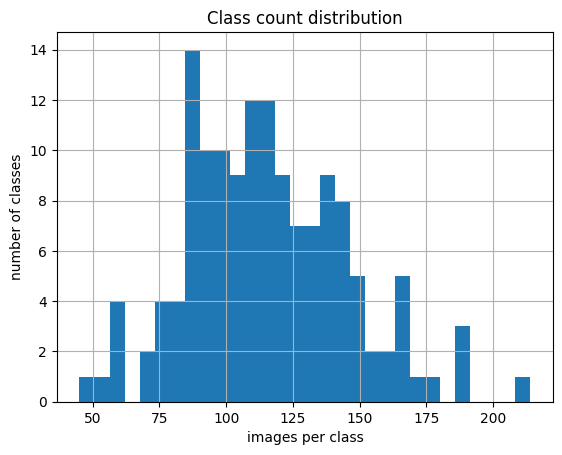

Min/median/max images per class: 45 113 214


In [5]:
class_counts = df_good["label"].value_counts()
print("Classes:", class_counts.shape[0])
print("Total images:", len(df_good))
display(class_counts.head(10))

plt.figure()
class_counts.hist(bins=30)
plt.title("Class count distribution")
plt.xlabel("images per class")
plt.ylabel("number of classes")
plt.show()

print("Min/median/max images per class:",
      int(class_counts.min()), int(class_counts.median()), int(class_counts.max()))


## 6) Train/Validation/Test split


In [6]:
# split test first
trainval_df, test_df = train_test_split(
    df_good,
    test_size=TEST_FRAC,
    random_state=SEED,
    stratify=df_good["label"],
)

# val fraction relative to remaining
rel_val = VAL_FRAC / (1.0 - TEST_FRAC)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=rel_val,
    random_state=SEED,
    stratify=trainval_df["label"],
)

print("Split sizes:")
print("train:", len(train_df), f"({len(train_df)/len(df_good):.3f})")
print("val:  ", len(val_df),   f"({len(val_df)/len(df_good):.3f})")
print("test: ", len(test_df),  f"({len(test_df)/len(df_good):.3f})")

train_df.to_csv(OUT_DIR/"train.csv", index=False)
val_df.to_csv(OUT_DIR/"val.csv", index=False)
test_df.to_csv(OUT_DIR/"test.csv", index=False)


Split sizes:
train: 13187 (0.800)
val:   1649 (0.100)
test:  1649 (0.100)


###  Augmentation 

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

AUG_TRAIN_DIR = OUT_DIR / "augmented_train"
AUG_TRAIN_DIR.mkdir(parents=True, exist_ok=True)

target_per_class = 120

counts = train_df["label"].value_counts()
need_total = int((target_per_class - counts).clip(lower=0).sum())
print("Target per class:", target_per_class)
print("Total new images to create:", need_total)

gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.12,
    shear_range=0.08,
    brightness_range=(0.85, 1.15),
    horizontal_flip=True,
    fill_mode="nearest"
)

new_rows = []

for label, c in counts.items():
    need = max(0, target_per_class - int(c))
    if need == 0:
        continue

    out_class_dir = AUG_TRAIN_DIR / label
    out_class_dir.mkdir(parents=True, exist_ok=True)

    class_paths = train_df.loc[train_df["label"] == label, "path"].values

    for i in range(need):
        src = np.random.choice(class_paths)
        img = keras.utils.load_img(src, target_size=IMG_SIZE)
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, 0)

        it = gen.flow(
            x,
            batch_size=1,
            save_to_dir=str(out_class_dir),
            save_prefix="aug",
            save_format="jpg"
        )
        _ = next(it)

    created = sorted(out_class_dir.glob("aug_*.jpg"))
    for p in created:
        new_rows.append((str(p), label))

aug_df = pd.DataFrame(new_rows, columns=["path", "label"])
train_df_aug = pd.concat([train_df, aug_df], ignore_index=True)

print("Original train:", len(train_df))
print("Augmented train:", len(train_df_aug))
print("Val:", len(val_df), "Test:", len(test_df))

# sanity: check class distribution
display(train_df_aug["label"].value_counts().describe())

train_df_aug.to_csv(OUT_DIR/"train_aug.csv", index=False)


Target per class: 120
Total new images to create: 4245


c:\Users\User\anaconda3\envs\tf-cpu\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Original train: 13187
Augmented train: 17425
Val: 1649 Test: 1649


count    143.000000
mean     121.853147
std        6.893514
min      118.000000
25%      120.000000
50%      120.000000
75%      120.000000
max      172.000000
Name: count, dtype: float64

In [8]:
print("Train class min/median/max after augmentation:")
vc = train_df_aug["label"].value_counts()
print(int(vc.min()), int(vc.median()), int(vc.max()))

Train class min/median/max after augmentation:
118 120 172


## 7) Label mapping + class imbalance handling


In [9]:
class_names = sorted(train_df["label"].unique().tolist())
label_to_id = {c:i for i,c in enumerate(class_names)}
id_to_label = {i:c for c,i in label_to_id.items()}
num_classes = len(class_names)

with open(OUT_DIR/"class_mapping.json", "w", encoding="utf-8") as f:
    json.dump({"label_to_id": label_to_id, "id_to_label": id_to_label}, f, indent=2)

train_counts = train_df["label"].value_counts()
total = train_counts.sum()

class_weights = {
    label_to_id[label]: float(total / (num_classes * count))
    for label, count in train_counts.items()
}

print("num_classes:", num_classes)
print("Example class weights (first 10):", list(class_weights.items())[:10])


num_classes: 143
Example class weights (first 10): [(95, 0.5361440884696699), (94, 0.6027240733123086), (56, 0.6189045853475383), (103, 0.623086373086373), (121, 0.6403943278943279), (128, 0.6830872830872831), (97, 0.6881849493789792), (38, 0.6986119940665395), (35, 0.6986119940665395), (104, 0.6986119940665395)]


## 8) Input pipeline (`tf.data`)


In [10]:
def decode_resize(path, label_id):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32)
    return img, label_id

def df_to_ds(df, training):
    paths = tf.constant(df["path"].values)
    labels = tf.constant([label_to_id[x] for x in df["label"].values], dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(min(len(df), 2000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = df_to_ds(train_df_aug, training=True)
val_ds   = df_to_ds(val_df, training=False)
test_ds  = df_to_ds(test_df, training=False)


next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape


(TensorShape([32, 160, 160, 3]), TensorShape([32]))

## 9) Visual sanity check


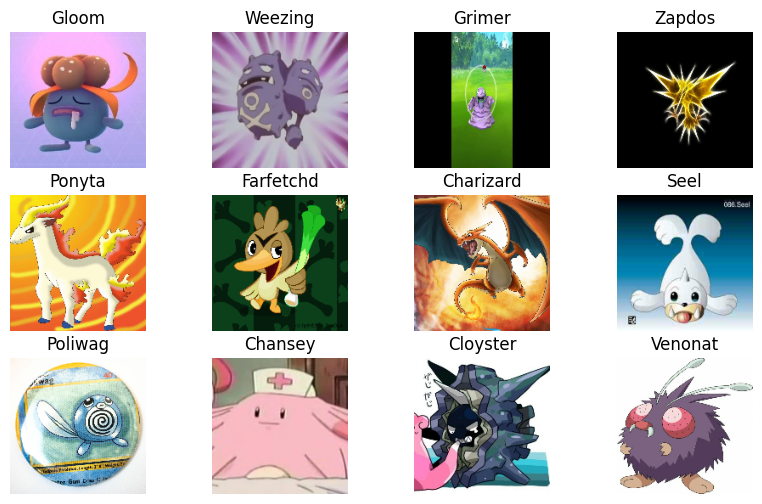

In [11]:
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 6))
for i in range(min(12, images.shape[0])):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow((images[i] / 255.0).numpy())
    plt.title(id_to_label[int(labels[i])])
    plt.axis("off")
plt.show()


## 10)callbacks


In [ ]:
def common_callbacks(run_name):
    return [
        keras.callbacks.ModelCheckpoint(
            OUT_DIR / f"{run_name}.best.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            restore_best_weights=True,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.3,
            patience=2,
            min_lr=1e-7
        ),
    ]


## 11) Experiment logging utilities


In [ ]:
HISTORIES = {}  # key: run_name, value: history object

def log_run(run_name, model_name, params, runtime_sec, best_val_acc, test_acc):
    RUNS_LOG.append({
        "run_name": run_name,
        "model": model_name,
        "params": json.dumps(params, ensure_ascii=False),
        "runtime_sec": float(runtime_sec),
        "best_val_acc": float(best_val_acc),
        "test_acc": float(test_acc),
    })
    pd.DataFrame(RUNS_LOG).to_csv(OUT_DIR/"runs_table.csv", index=False)

def train_and_eval(model, run_name, epochs):
    t0 = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=common_callbacks(run_name),
        verbose=1
    )
    runtime = time.time() - t0
    best_val = float(np.max(history.history["val_accuracy"]))
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    HISTORIES[run_name] = history

    return history, runtime, best_val, float(test_acc)




In [14]:
import matplotlib.pyplot as plt
import numpy as np


def plot_history(history, title="Training Curves"):
    h = history.history

    # Accuracy
    if "accuracy" in h:
        plt.figure()
        plt.plot(h["accuracy"], label="train_acc")
        if "val_accuracy" in h:
            plt.plot(h["val_accuracy"], label="val_acc")
        plt.title(f"{title} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Loss
    if "loss" in h:
        plt.figure()
        plt.plot(h["loss"], label="train_loss")
        if "val_loss" in h:
            plt.plot(h["val_loss"], label="val_loss")
        plt.title(f"{title} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()


## 12) Baseline A — Small CNN


In [16]:
def build_small_cnn(num_classes, dropout=0.35):
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = inputs
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="small_cnn")

baseline_cnn = build_small_cnn(num_classes)
baseline_cnn.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

hist_a, rt_a, best_val_a, test_a = train_and_eval(
    baseline_cnn, "A_small_cnn", epochs=15
)

log_run("A_small_cnn", baseline_cnn.name,
        params={"lr":1e-3, "epochs":15, "dropout":0.35, "aug":"basic", "class_weights":True},
        runtime_sec=rt_a, best_val_acc=best_val_a, test_acc=test_a)

best_val_a, test_a


Epoch 1/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.0196 - loss: 4.8095 - val_accuracy: 0.0182 - val_loss: 4.7526 - learning_rate: 0.0010
Epoch 2/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.0615 - loss: 4.2062 - val_accuracy: 0.0370 - val_loss: 4.3565 - learning_rate: 0.0010
Epoch 3/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.1043 - loss: 3.8542 - val_accuracy: 0.0588 - val_loss: 4.1813 - learning_rate: 0.0010
Epoch 4/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.1432 - loss: 3.6322 - val_accuracy: 0.1025 - val_loss: 3.7482 - learning_rate: 0.0010
Epoch 5/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.1740 - loss: 3.4485 - val_accuracy: 0.0976 - val_loss: 3.8575 - learning_rate: 0.0010
Epoch 6/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.1984 - loss: 3.3434 - val_accuracy: 0.1152 - val_loss: 3.6753 - learning_rate: 0.0010
Epoch 7/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.2248 - l

(0.29351121187210083, 0.29714977741241455)

## 13) Baseline B — Simple model comparison


In [17]:
from sklearn.linear_model import LogisticRegression

# Build a fixed feature extractor (pretrained) and train a simple model on top
feature_extractor = keras.applications.MobileNetV3Small(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,), pooling="avg"
)

def ds_to_features(ds):
    Xs, ys = [], []
    for imgs, y in ds:
        x = keras.applications.mobilenet_v3.preprocess_input(imgs)
        feats = feature_extractor(x, training=False).numpy()
        Xs.append(feats)
        ys.append(y.numpy())
    return np.vstack(Xs), np.concatenate(ys)

t0 = time.time()
X_train, y_train = ds_to_features(train_ds)
X_val, y_val     = ds_to_features(val_ds)
X_test, y_test   = ds_to_features(test_ds)
runtime = time.time() - t0

clf = LogisticRegression(max_iter=2000, n_jobs=-1, verbose=0)
clf.fit(X_train, y_train)
val_acc = clf.score(X_val, y_val)
test_acc = clf.score(X_test, y_test)

log_run("B_lr_on_mobilenet_features", "LogReg(MobileNetV3 features)",
        params={"max_iter":2000}, runtime_sec=runtime,
        best_val_acc=val_acc, test_acc=test_acc)

val_acc, test_acc


c:\Users\User\anaconda3\envs\tf-cpu\lib\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


(0.7956337174044875, 0.8283808368708309)

## 14) Advanced Model 1 — EfficientNetB0 (transfer learning)


In [ ]:
def sparse_cce_with_label_smoothing(num_classes, label_smoothing=0.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes)

        if label_smoothing and label_smoothing > 0.0:
            smooth = label_smoothing / num_classes
            y_true_oh = (1.0 - label_smoothing) * y_true_oh + smooth

        return tf.keras.losses.categorical_crossentropy(y_true_oh, y_pred)
    return loss


In [22]:
def build_efficientnet(num_classes, dropout=0.35, label_smoothing=0.0):
    base = keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
    )
    base.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = inputs
    x = keras.applications.efficientnet.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetB0_transfer")
    loss = sparse_cce_with_label_smoothing(num_classes, label_smoothing=label_smoothing)
    return model, base, loss


eff_model, eff_base, eff_loss = build_efficientnet(num_classes, dropout=0.35, label_smoothing=0.05)
eff_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=eff_loss, metrics=["accuracy"])

# Frozen stage
hist_c1, rt_c1, best_val_c1, test_c1 = train_and_eval(
    eff_model, "C1_effnet_frozen", epochs=15
)
log_run("C1_effnet_frozen", eff_model.name,
        params={"lr":1e-3,"epochs":15,"frozen":True,"dropout":0.35,"label_smoothing":0.05},
        runtime_sec=rt_c1, best_val_acc=best_val_c1, test_acc=test_c1)

# Fine-tune stage (last N layers)
eff_base.trainable = True
for layer in eff_base.layers[:-30]:
    layer.trainable = False

eff_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=eff_loss, metrics=["accuracy"])
hist_c2, rt_c2, best_val_c2, test_c2 = train_and_eval(
    eff_model, "C2_effnet_finetune", epochs=10
)
log_run("C2_effnet_finetune", eff_model.name,
        params={"lr":1e-5,"epochs":10,"frozen":False,"finetune_last":30,"dropout":0.35,"label_smoothing":0.05},
        runtime_sec=rt_c2, best_val_acc=best_val_c2, test_acc=test_c2)

max(best_val_c1, best_val_c2), test_c2


Epoch 1/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 57s 98ms/step - accuracy: 0.3424 - loss: 3.4938 - val_accuracy: 0.6725 - val_loss: 1.8411 - learning_rate: 0.0010
Epoch 2/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.7832 - loss: 1.4745 - val_accuracy: 0.7629 - val_loss: 1.4805 - learning_rate: 0.0010
Epoch 3/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.8476 - loss: 1.1948 - val_accuracy: 0.7926 - val_loss: 1.3456 - learning_rate: 0.0010
Epoch 4/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - accuracy: 0.8842 - loss: 1.0686 - val_accuracy: 0.8017 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 5/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.9093 - loss: 0.9783 - val_accuracy: 0.8078 - val_loss: 1.2610 - learning_rate: 0.0010
Epoch 6/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - accuracy: 0.9214 - loss: 0.9383 - val_accuracy: 0.8211 - val_loss: 1.2389 - learning_rate: 0.0010
Epoch 7/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 54s 100ms/step - accuracy: 0.9329 

(0.8483929634094238, 0.8641601204872131)

## 15) Advanced Model 2 — MobileNetV3Large


In [24]:
def build_mobilenetv3(num_classes, dropout=0.3, label_smoothing=0.0):
    base = keras.applications.MobileNetV3Large(
        include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
    )
    base.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = inputs
    x = keras.applications.mobilenet_v3.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="MobileNetV3Large_transfer")
    loss = sparse_cce_with_label_smoothing(num_classes, label_smoothing=label_smoothing)
    return model, base, loss


mnet, mnet_base, mnet_loss = build_mobilenetv3(num_classes, dropout=0.3, label_smoothing=0.05)
mnet.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mnet_loss, metrics=["accuracy"])

hist_d1, rt_d1, best_val_d1, test_d1 = train_and_eval(
    mnet, "D1_mnet_frozen", epochs=12
)
log_run("D1_mnet_frozen", mnet.name,
        params={"lr":1e-3,"epochs":12,"frozen":True,"dropout":0.3,"label_smoothing":0.05},
        runtime_sec=rt_d1, best_val_acc=best_val_d1, test_acc=test_d1)

best_val_d1, test_d1


Epoch 1/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.2994 - loss: 3.6459 - val_accuracy: 0.6944 - val_loss: 1.7066 - learning_rate: 0.0010
Epoch 2/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.7853 - loss: 1.3785 - val_accuracy: 0.7568 - val_loss: 1.4633 - learning_rate: 0.0010
Epoch 3/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.8558 - loss: 1.1403 - val_accuracy: 0.7932 - val_loss: 1.3512 - learning_rate: 0.0010
Epoch 4/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.8957 - loss: 1.0206 - val_accuracy: 0.8041 - val_loss: 1.3267 - learning_rate: 0.0010
Epoch 5/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.9178 - loss: 0.9502 - val_accuracy: 0.8096 - val_loss: 1.2844 - learning_rate: 0.0010
Epoch 6/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.9343 - loss: 0.8940 - val_accuracy: 0.8150 - val_loss: 1.2885 - learning_rate: 0.0010
Epoch 7/12
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.9394 - l

(0.8277744054794312, 0.8599150776863098)

## 16) Hyperparameter tuning


In [25]:
# Quick controlled tuning on EfficientNet head (fast): vary dropout and label_smoothing
tuning_results = []

for dropout in [0.2, 0.35, 0.5]:
    for ls in [0.0, 0.05, 0.1]:
        run_name = f"T_eff_d{dropout}_ls{ls}"
        model, base, loss = build_efficientnet(num_classes, dropout=dropout, label_smoothing=ls)
        model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])

        hist, rt, best_val, test_acc = train_and_eval(model, run_name, epochs=8)

        tuning_results.append({
            "dropout": dropout, "label_smoothing": ls,
            "best_val_acc": best_val, "test_acc": test_acc, "runtime_sec": rt
        })

tuning_df = pd.DataFrame(tuning_results).sort_values("best_val_acc", ascending=False)
tuning_df.head(10)


Epoch 1/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 60s 105ms/step - accuracy: 0.3751 - loss: 3.2333 - val_accuracy: 0.6962 - val_loss: 1.4469 - learning_rate: 0.0010
Epoch 2/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accuracy: 0.8066 - loss: 0.9862 - val_accuracy: 0.7647 - val_loss: 1.0415 - learning_rate: 0.0010
Epoch 3/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 55s 101ms/step - accuracy: 0.8694 - loss: 0.6531 - val_accuracy: 0.7932 - val_loss: 0.8795 - learning_rate: 0.0010
Epoch 4/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 54s 100ms/step - accuracy: 0.9093 - loss: 0.4755 - val_accuracy: 0.8041 - val_loss: 0.7967 - learning_rate: 0.0010
Epoch 5/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accuracy: 0.9332 - loss: 0.3646 - val_accuracy: 0.8041 - val_loss: 0.7523 - learning_rate: 0.0010
Epoch 6/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 0.9477 - loss: 0.2927 - val_accuracy: 0.8169 - val_loss: 0.7156 - learning_rate: 0.0010
Epoch 7/8
545/545 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - accuracy: 0.9525 - l

dropout  label_smoothing  best_val_acc  test_acc  runtime_sec
2     0.20             0.10      0.830200  0.851425   445.213696
4     0.35             0.05      0.828381  0.855670   520.364473
8     0.50             0.10      0.823529  0.848999   502.596519
1     0.20             0.05      0.822317  0.852638   451.514075
5     0.35             0.10      0.821104  0.843542   488.864762
3     0.35             0.00      0.818678  0.844754   457.544774
0     0.20             0.00      0.817465  0.856277   446.021828
6     0.50             0.00      0.816859  0.844754   508.885221
7     0.50             0.05      0.814433  0.855670   506.683300

## 17) Compare runs + select best model


run_name                         model  \
3          C2_effnet_finetune       EfficientNetB0_transfer   
2            C1_effnet_frozen       EfficientNetB0_transfer   
4              D1_mnet_frozen     MobileNetV3Large_transfer   
1  B_lr_on_mobilenet_features  LogReg(MobileNetV3 features)   
0                 A_small_cnn                     small_cnn   

                                              params  runtime_sec  \
3  {"lr": 1e-05, "epochs": 10, "frozen": false, "...   654.727365   
2  {"lr": 0.001, "epochs": 15, "frozen": true, "d...   821.825073   
4  {"lr": 0.001, "epochs": 12, "frozen": true, "d...   367.454903   
1                                 {"max_iter": 2000}    62.518567   
0  {"lr": 0.001, "epochs": 15, "dropout": 0.35, "...   680.450778   

   best_val_acc  test_acc  
3      0.848393  0.864160  
2      0.840509  0.863554  
4      0.827774  0.859915  
1      0.795634  0.828381  
0      0.293511  0.297150

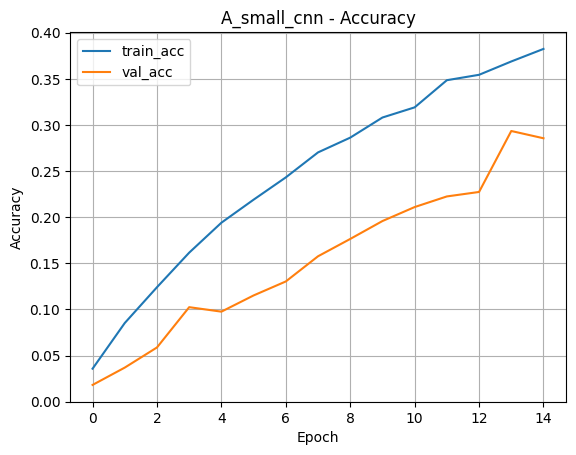

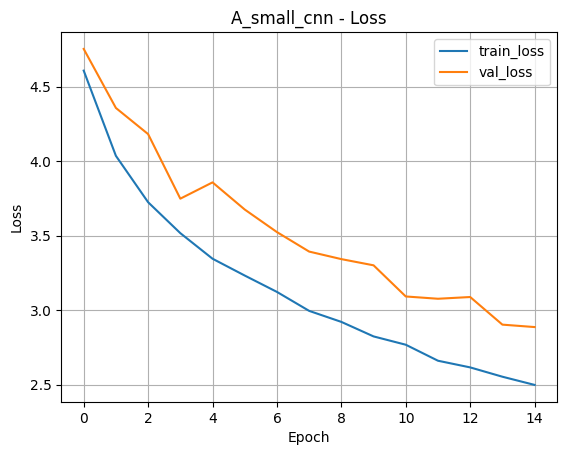

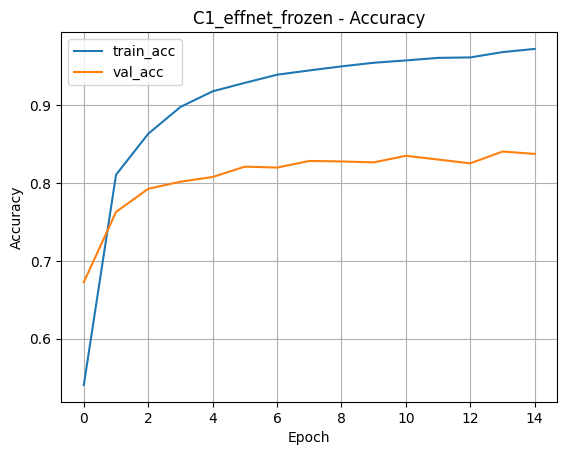

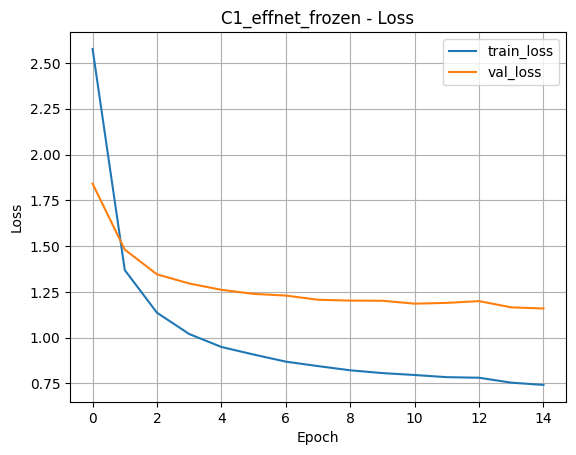

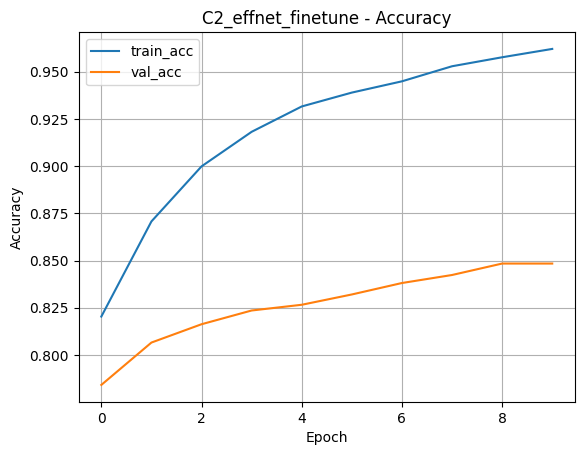

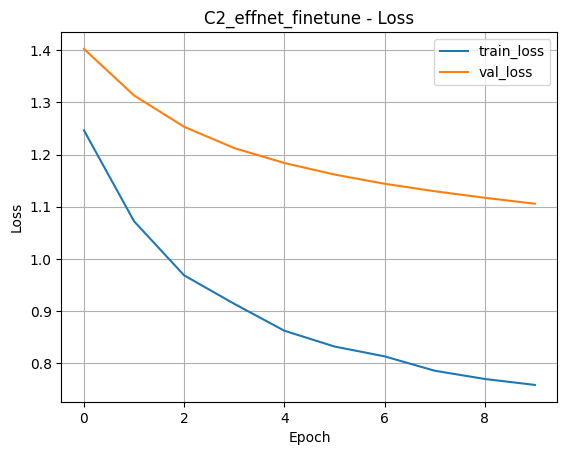

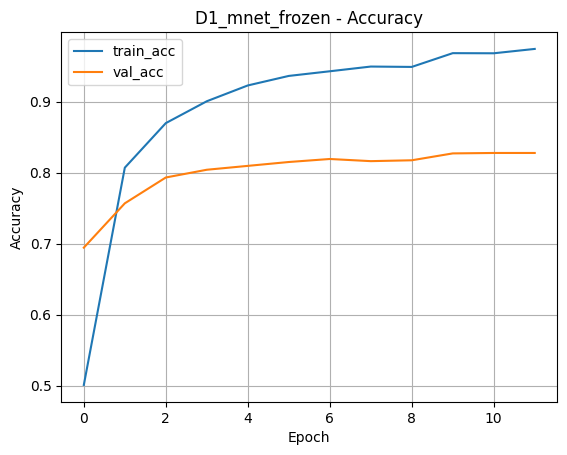

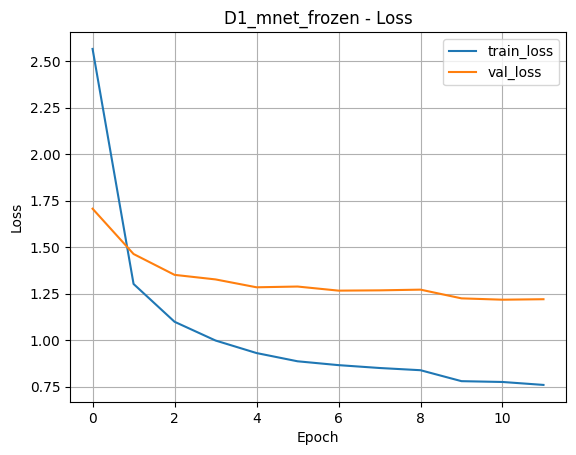

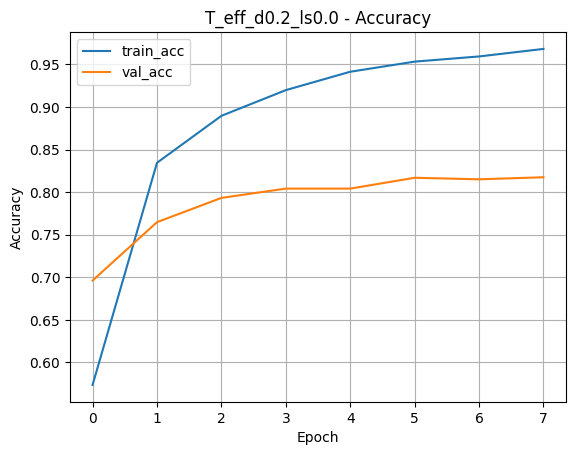

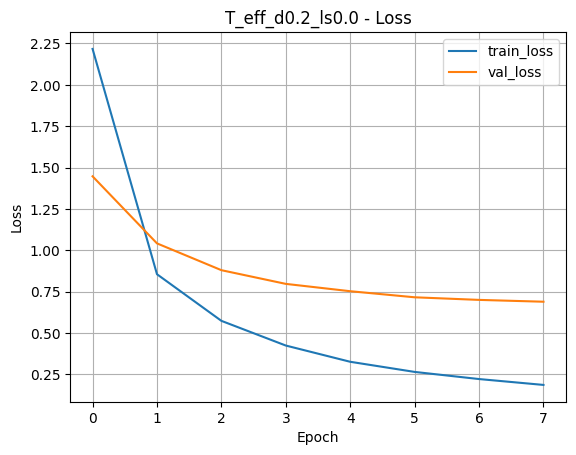

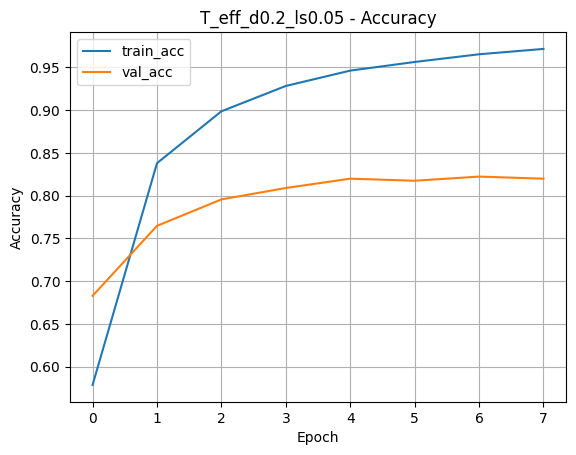

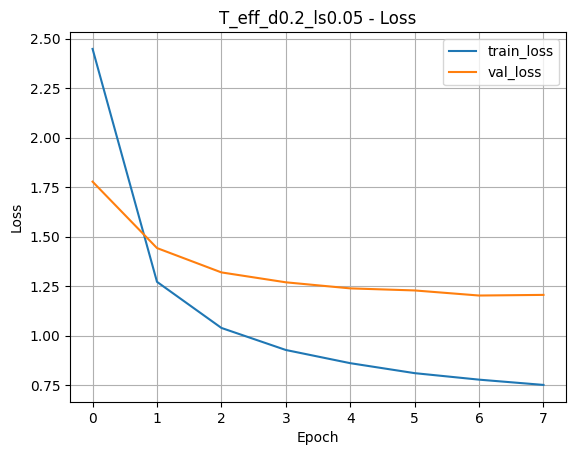

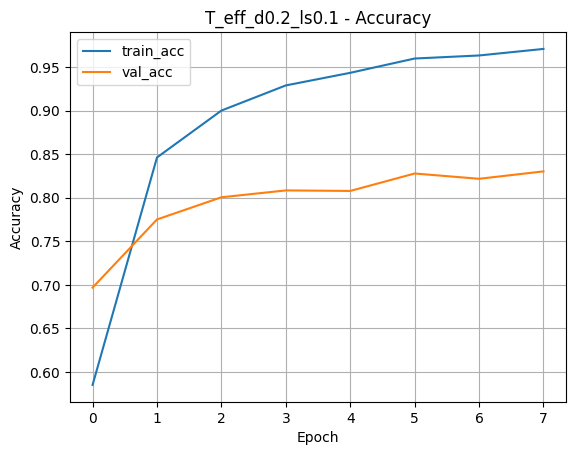

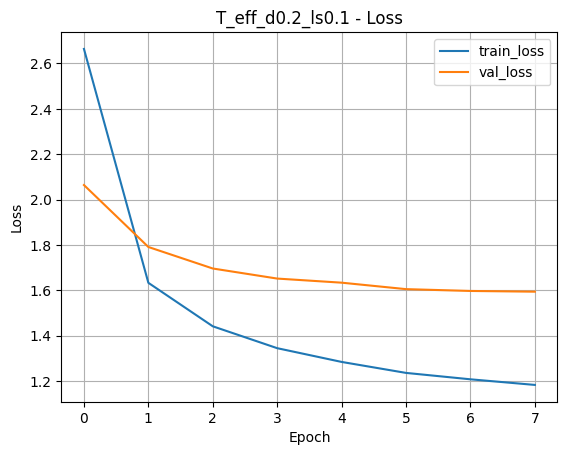

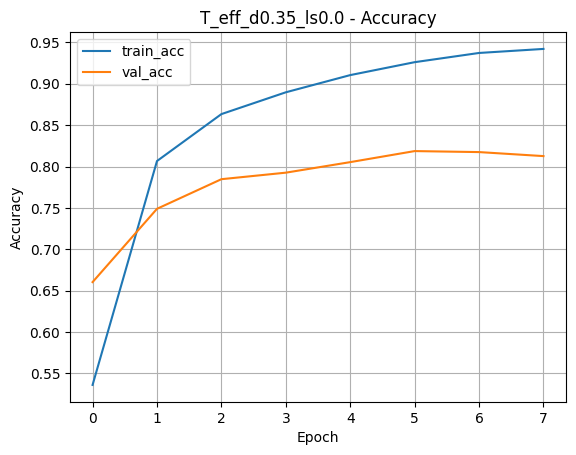

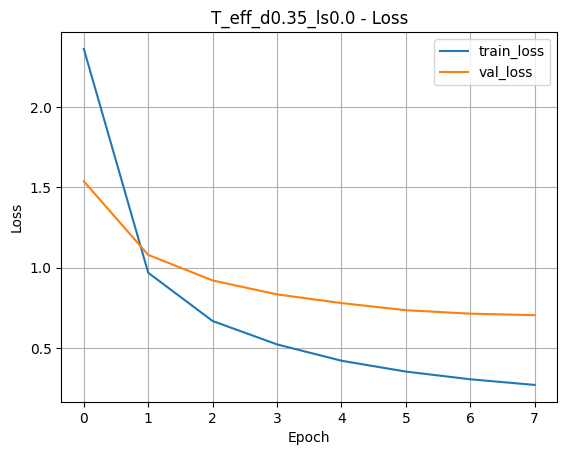

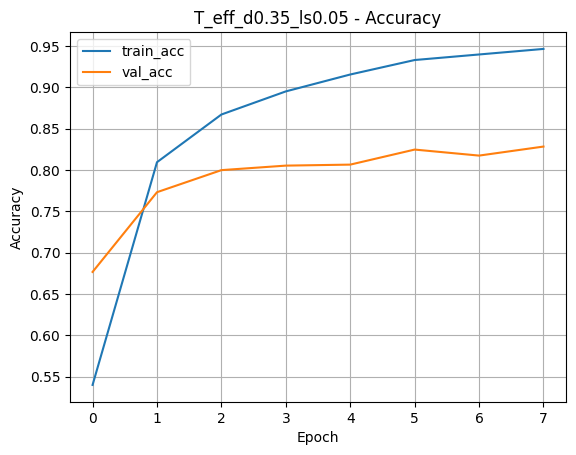

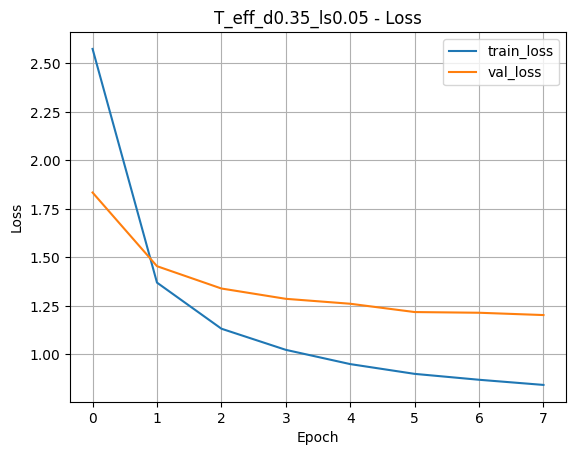

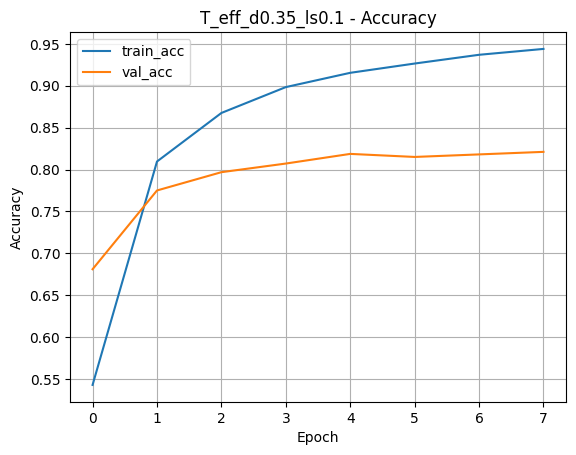

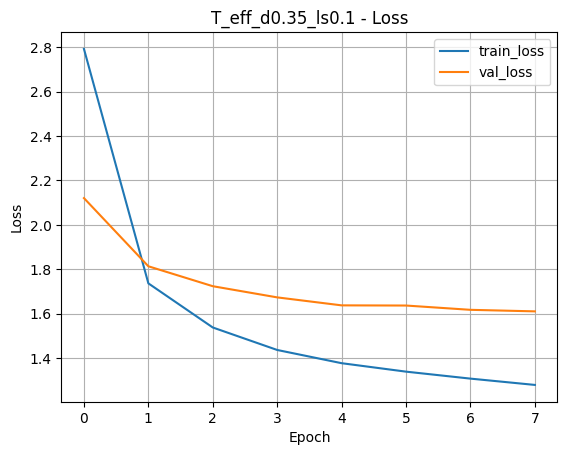

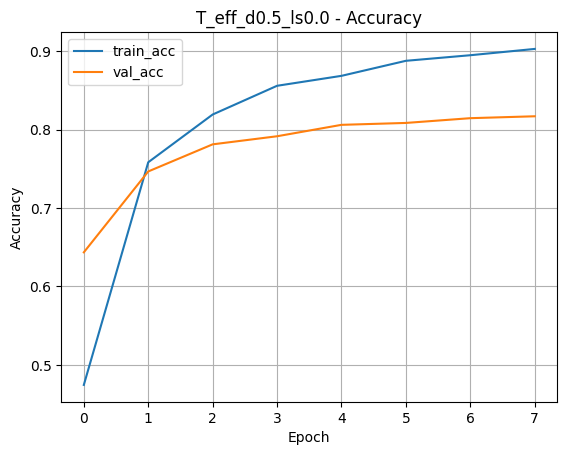

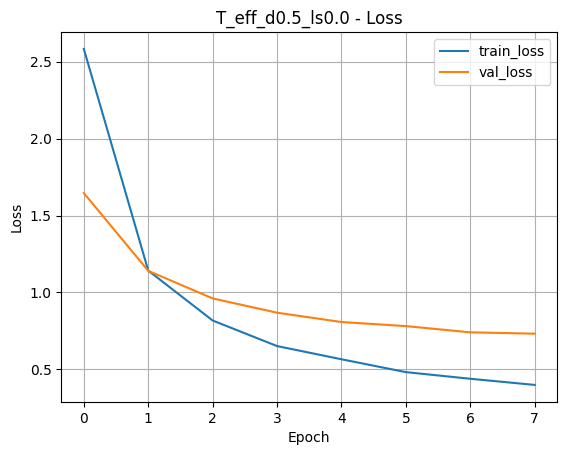

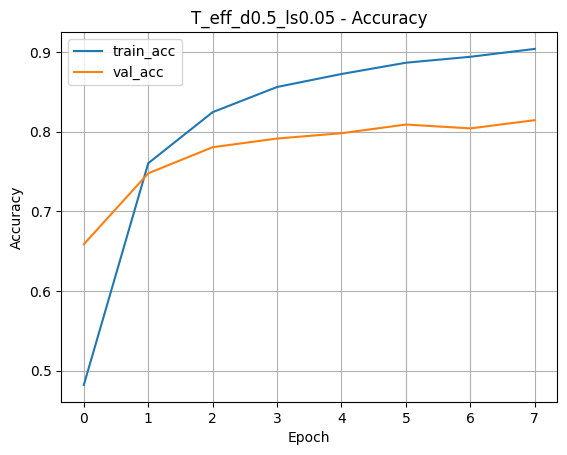

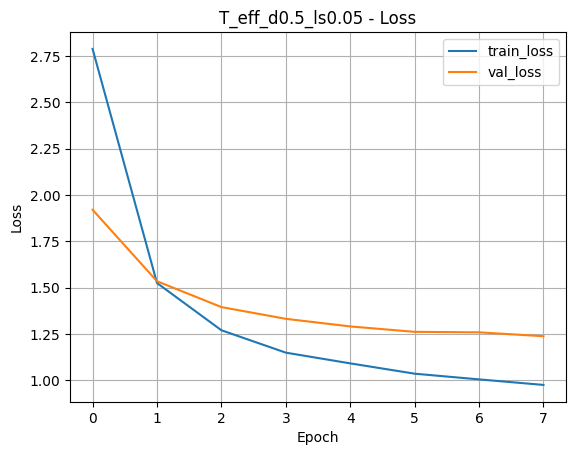

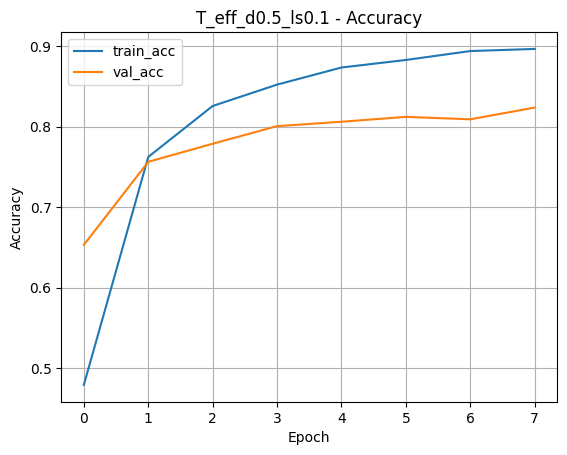

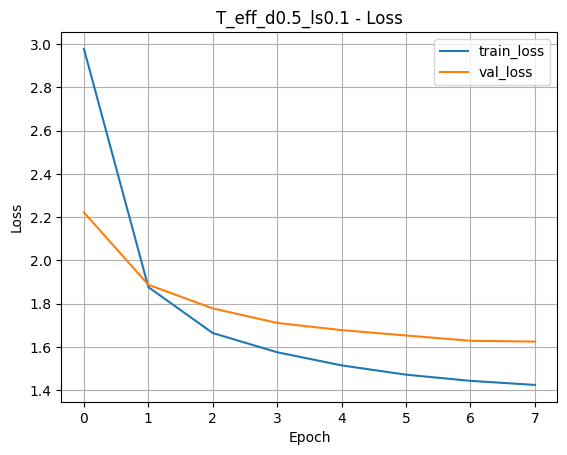

In [26]:
runs_df = pd.DataFrame(RUNS_LOG).sort_values("best_val_acc", ascending=False)
display(runs_df.head(10))
runs_df.to_csv(OUT_DIR/"runs_table.csv", index=False)

best_run = runs_df.iloc[0]
best_run
for run_name, hist in HISTORIES.items():
    plot_history(hist, run_name)


run_name  best_val_acc  test_acc  runtime_sec
0          C2_effnet_finetune      0.848393  0.864160   654.727365
1            C1_effnet_frozen      0.840509  0.863554   821.825073
2              D1_mnet_frozen      0.827774  0.859915   367.454903
3  B_lr_on_mobilenet_features      0.795634  0.828381    62.518567
4                 A_small_cnn      0.293511  0.297150   680.450778

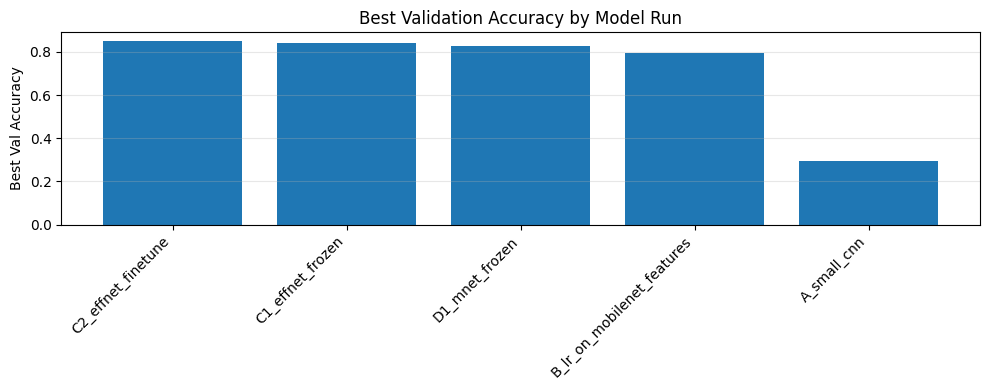

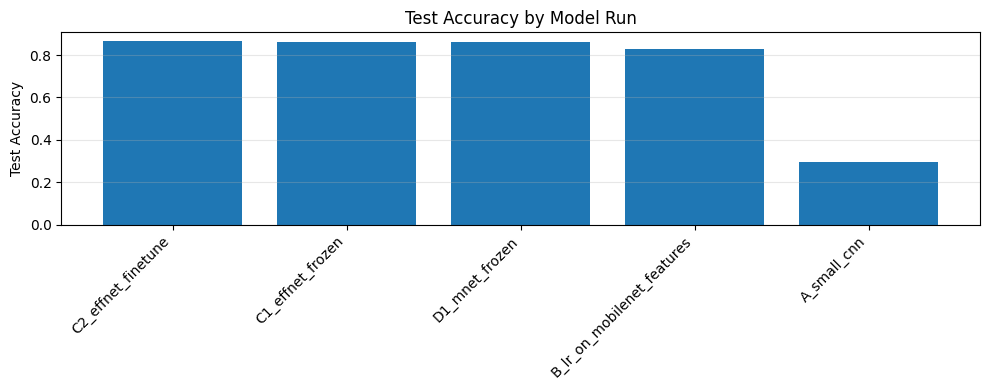

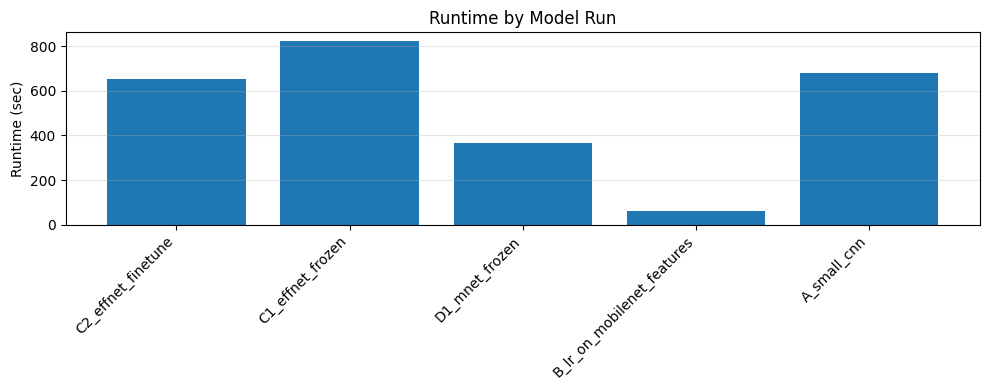

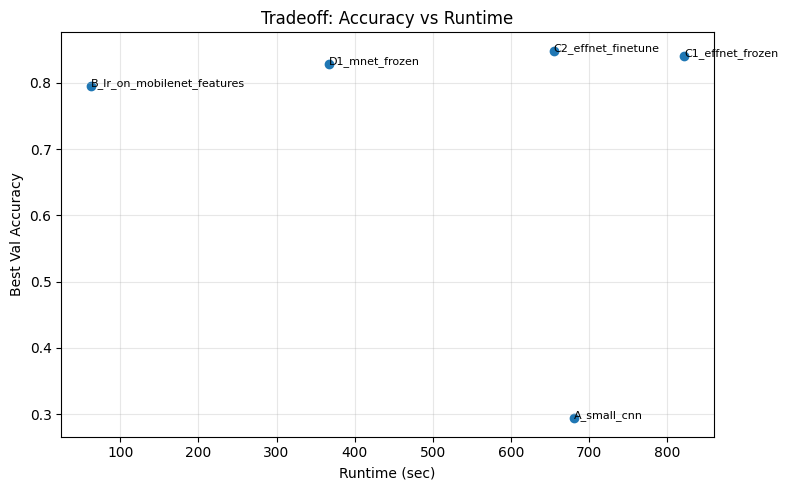

BEST RUN (by val):
  run_name      : C2_effnet_finetune
  best_val_acc  : 0.8484
  test_acc      : 0.8642
  runtime_sec   : 654.7


run_name  best_val_acc  test_acc  runtime_sec
0  C2_effnet_finetune      0.848393  0.864160   654.727365
1    C1_effnet_frozen      0.840509  0.863554   821.825073
2      D1_mnet_frozen      0.827774  0.859915   367.454903

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load runs table (works whether you kept RUNS_LOG in memory or saved CSV)
runs_csv = OUT_DIR / "runs_table.csv"

if "RUNS_LOG" in globals() and len(RUNS_LOG) > 0:
    runs_df = pd.DataFrame(RUNS_LOG).copy()
elif runs_csv.exists():
    runs_df = pd.read_csv(runs_csv)
else:
    raise ValueError("No runs found. Make sure you ran models and logged them into RUNS_LOG / runs_table.csv")

# Basic cleanup / ordering
runs_df = runs_df.sort_values("best_val_acc", ascending=False).reset_index(drop=True)

display(runs_df[["run_name", "best_val_acc", "test_acc", "runtime_sec"]])

# ---------
# 1) Bar: Best Val Accuracy
# ---------
plt.figure(figsize=(10,4))
plt.bar(runs_df["run_name"], runs_df["best_val_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Best Val Accuracy")
plt.title("Best Validation Accuracy by Model Run")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------
# 2) Bar: Test Accuracy
# ---------
plt.figure(figsize=(10,4))
plt.bar(runs_df["run_name"], runs_df["test_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy by Model Run")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------
# 3) Bar: Runtime (seconds)
# ---------
plt.figure(figsize=(10,4))
plt.bar(runs_df["run_name"], runs_df["runtime_sec"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Runtime (sec)")
plt.title("Runtime by Model Run")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------
# 4) Scatter: Accuracy vs Runtime (tradeoff)
# ---------
plt.figure(figsize=(8,5))
plt.scatter(runs_df["runtime_sec"], runs_df["best_val_acc"])
for _, r in runs_df.iterrows():
    plt.text(r["runtime_sec"], r["best_val_acc"], r["run_name"], fontsize=8)

plt.xlabel("Runtime (sec)")
plt.ylabel("Best Val Accuracy")
plt.title("Tradeoff: Accuracy vs Runtime")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------
# 5) Summary: Best run + Top-3 table
# ---------
best = runs_df.iloc[0]
print("BEST RUN (by val):")
print(f"  run_name      : {best['run_name']}")
print(f"  best_val_acc  : {best['best_val_acc']:.4f}")
print(f"  test_acc      : {best['test_acc']:.4f}")
print(f"  runtime_sec   : {best['runtime_sec']:.1f}")

display(runs_df.head(3)[["run_name", "best_val_acc", "test_acc", "runtime_sec"]])


## 18) Load best checkpoint


In [28]:
best_ckpt = OUT_DIR / f"{best_run['run_name']}.best.keras"
print("Loading:", best_ckpt)
best_model = keras.models.load_model(best_ckpt, compile=False)
best_model.summary()
best_model.summary()


Loading: outputs\C2_effnet_finetune.best.keras


Model: "EfficientNetB0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 143)            │       183,183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,232,754 (16.15 MB)

 Trainable params: 1,679,343 (6.41 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

Model: "EfficientNetB0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 143)            │       183,183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,232,754 (16.15 MB)

 Trainable params: 1,679,343 (6.41 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

## 19) Final TEST evaluation


In [29]:
# Collect predictions
y_true = []
y_pred = []

for imgs, y in test_ds:
    probs = best_model.predict(imgs, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = float((y_true == y_pred).mean())
print("FINAL TEST ACC:", test_acc)

report = classification_report(
    y_true, y_pred,
    target_names=[id_to_label[i] for i in range(num_classes)],
    zero_division=0
)
print(report)

cm = confusion_matrix(y_true, y_pred)
np.save(OUT_DIR/"confusion_matrix.npy", cm)
(Path(OUT_DIR/"classification_report.txt")).write_text(report, encoding="utf-8")


FINAL TEST ACC: 0.8641600970285022
              precision    recall  f1-score   support

        Abra       0.29      0.33      0.31         6
  Aerodactyl       0.75      0.75      0.75         8
    Alakazam       0.88      0.88      0.88         8
       Arbok       0.92      0.85      0.88        13
    Arcanine       0.75      0.75      0.75         8
    Articuno       0.70      0.78      0.74         9
    Beedrill       1.00      0.89      0.94         9
  Bellsprout       0.93      1.00      0.96        13
   Blastoise       0.75      0.86      0.80        14
   Bulbasaur       1.00      0.93      0.97        15
  Butterfree       1.00      1.00      1.00        12
    Caterpie       0.86      0.92      0.89        13
     Chansey       1.00      1.00      1.00        11
   Charizard       0.83      1.00      0.91        10
  Charmander       1.00      0.92      0.96        13
  Charmeleon       0.93      0.93      0.93        15
    Clefable       1.00      0.70      0.82   

7940

## 20) Confusion matrix visualization

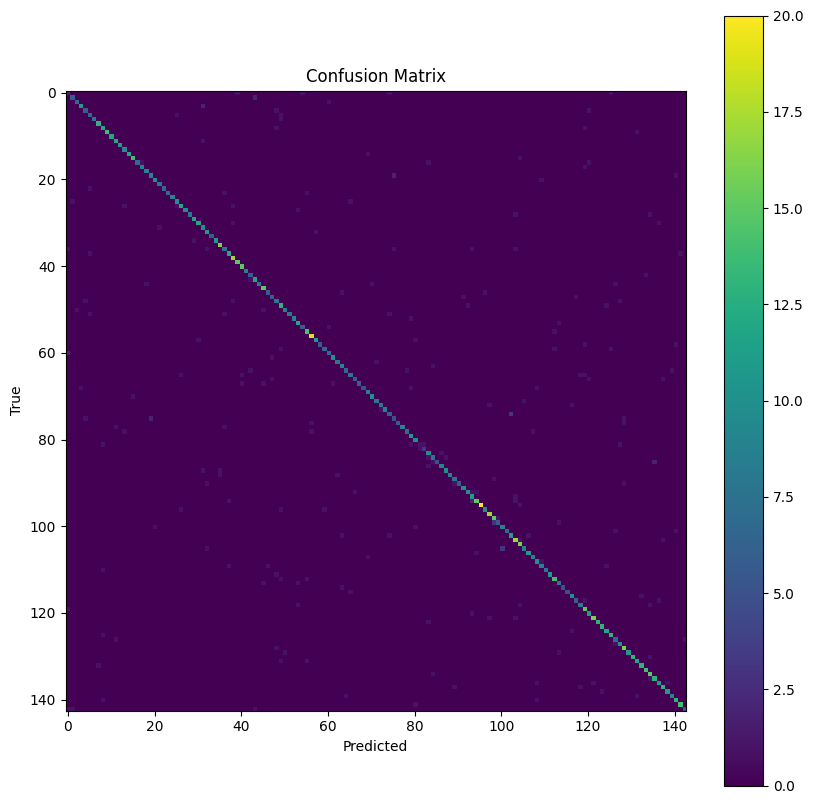

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


## 21) Most confused pairs (error analysis)


In [31]:
cm2 = cm.copy()
np.fill_diagonal(cm2, 0)

pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if cm2[i,j] > 0:
            pairs.append((cm2[i,j], id_to_label[i], id_to_label[j]))

pairs = sorted(pairs, reverse=True)[:20]
pd.DataFrame(pairs, columns=["count", "true_label", "pred_label"])


count  true_label  pred_label
0       3    Rapidash      Ponyta
1       3   Poliwrath   Poliwhirl
2       3      Mankey    Primeape
3       2      Pidgey   Pidgeotto
4       2    Nidorina      Vulpix
5       2     Marowak      Cubone
6       2     Kadabra        Abra
7       2      Cubone     Marowak
8       2       Arbok       Ekans
9       2  Aerodactyl      Golbat
10      1       Zubat      Golbat
11      1       Zubat  Aerodactyl
12      1       Zubat        Abra
13      1      Zapdos     Moltres
14      1  Wigglytuff      Rhydon
15      1  Wigglytuff   Blastoise
16      1     Weezing    Venusaur
17      1     Weezing     Koffing
18      1  Weepinbell      Staryu
19      1      Weedle    Slowpoke

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

def show_confusion_pair_examples(
    test_df,
    y_true,
    y_pred,
    id_to_label,
    true_label,
    pred_label,
    probs=None,
    n_mis=3,
    n_true=3,
    n_pred=3,
    img_size=None
):
    """
    Shows:
      - misclassified: true=true_label, pred=pred_label
      - correct A: true=true_label, pred=true_label
      - correct B: true=pred_label, pred=pred_label
    """

    y_true_name = np.array([id_to_label[int(i)] for i in y_true])
    y_pred_name = np.array([id_to_label[int(i)] for i in y_pred])

    paths = test_df["path"].values

    mis_idx  = np.where((y_true_name == true_label) & (y_pred_name == pred_label))[0]
    true_idx = np.where((y_true_name == true_label) & (y_pred_name == true_label))[0]
    pred_idx = np.where((y_true_name == pred_label) & (y_pred_name == pred_label))[0]

    def pick(idxs, k):
        if len(idxs) == 0:
            return []
        k = min(k, len(idxs))
        return list(np.random.choice(idxs, size=k, replace=False))

    mis_pick  = pick(mis_idx, n_mis)
    true_pick = pick(true_idx, n_true)
    pred_pick = pick(pred_idx, n_pred)

    max_rows = max(len(true_pick), len(mis_pick), len(pred_pick))
    cols = 3
    plt.figure(figsize=(cols * 4, max_rows * 4))

    def load_img(p):
        if img_size is None:
            return keras.utils.load_img(p)
        return keras.utils.load_img(p, target_size=img_size)

    def title_for(idx, mode):
        if probs is None:
            return mode
        conf = float(np.max(probs[idx]))
        return f"{mode}\nconf={conf:.2f}"

    for r in range(max_rows):
        ax = plt.subplot(max_rows, cols, r*cols + 1)
        if r < len(true_pick):
            i = true_pick[r]
            ax.imshow(load_img(paths[i]))
            ax.set_title(title_for(i, f"Correct: {true_label}"), fontsize=10)
        else:
            ax.axis("off")
        ax.axis("off")

        ax = plt.subplot(max_rows, cols, r*cols + 2)
        if r < len(mis_pick):
            i = mis_pick[r]
            ax.imshow(load_img(paths[i]))
            ax.set_title(title_for(i, f"MIS: {true_label} → {pred_label}"), fontsize=10)
        else:
            ax.axis("off")
        ax.axis("off")


        ax = plt.subplot(max_rows, cols, r*cols + 3)
        if r < len(pred_pick):
            i = pred_pick[r]
            ax.imshow(load_img(paths[i]))
            ax.set_title(title_for(i, f"Correct: {pred_label}"), fontsize=10)
        else:
            ax.axis("off")
        ax.axis("off")

    plt.suptitle(f"Confusion Pair Gallery: {true_label} → {pred_label}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"Counts in test:")
    print(f"  Misclassified {true_label} → {pred_label}: {len(mis_idx)}")
    print(f"  Correct {true_label}: {len(true_idx)}")
    print(f"  Correct {pred_label}: {len(pred_idx)}")


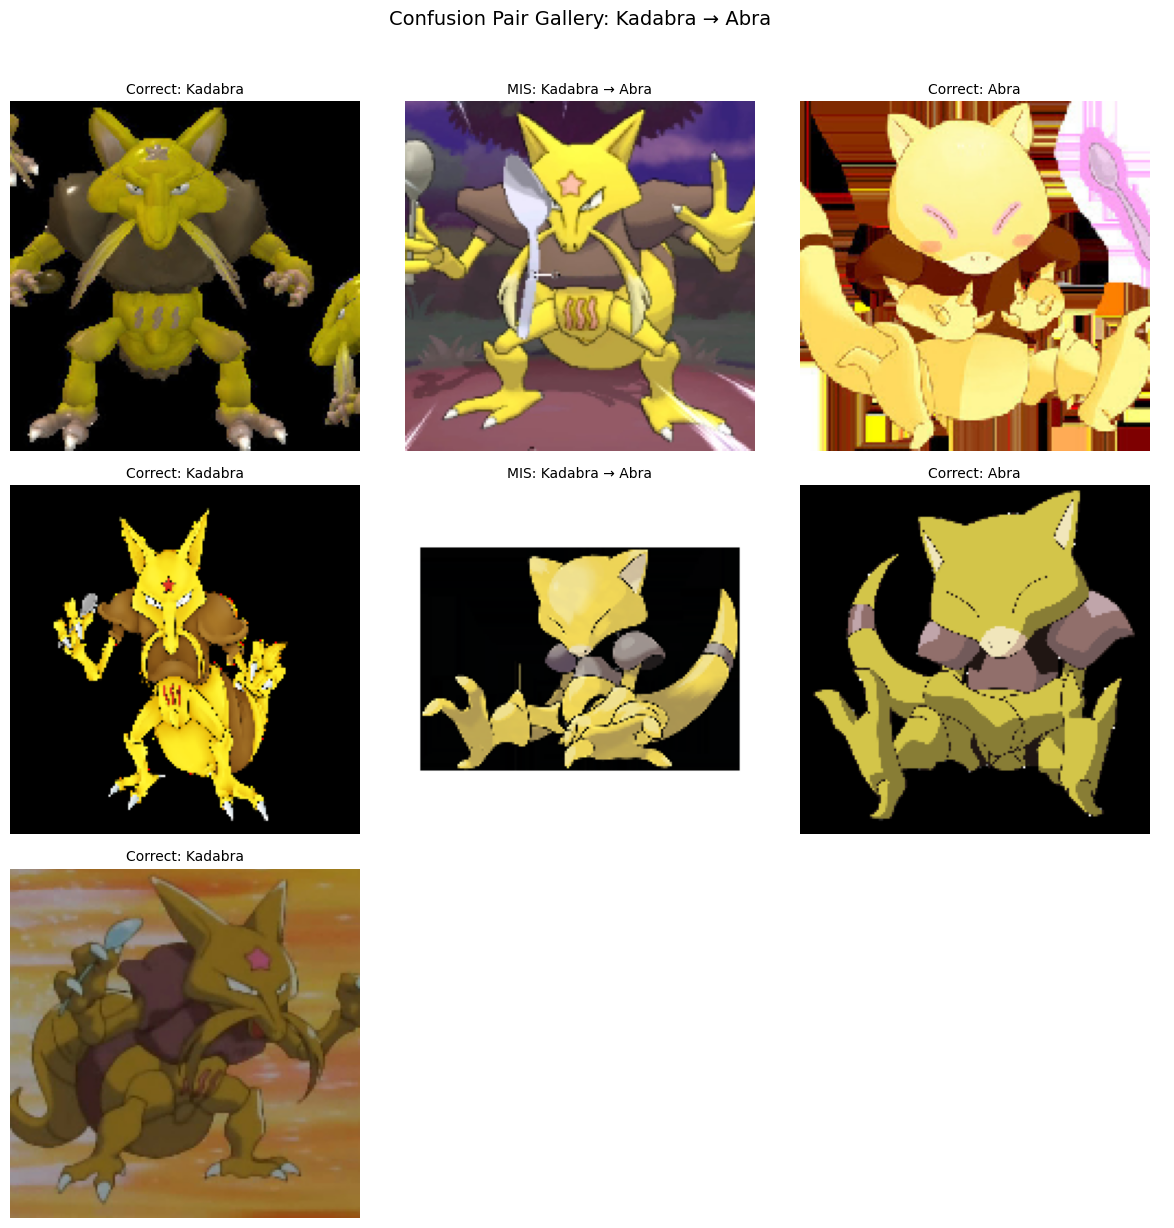

Counts in test:
  Misclassified Kadabra → Abra: 2
  Correct Kadabra: 7
  Correct Abra: 2


In [41]:
show_confusion_pair_examples(
    test_df=test_df,
    y_true=y_true,
    y_pred=y_pred,
    id_to_label=id_to_label,
    true_label="Kadabra",
    pred_label="Abra",
    probs=None,
    n_mis=3, n_true=3, n_pred=3,
    img_size=IMG_SIZE
)


## 22) Qualitative examples


3 Correct:


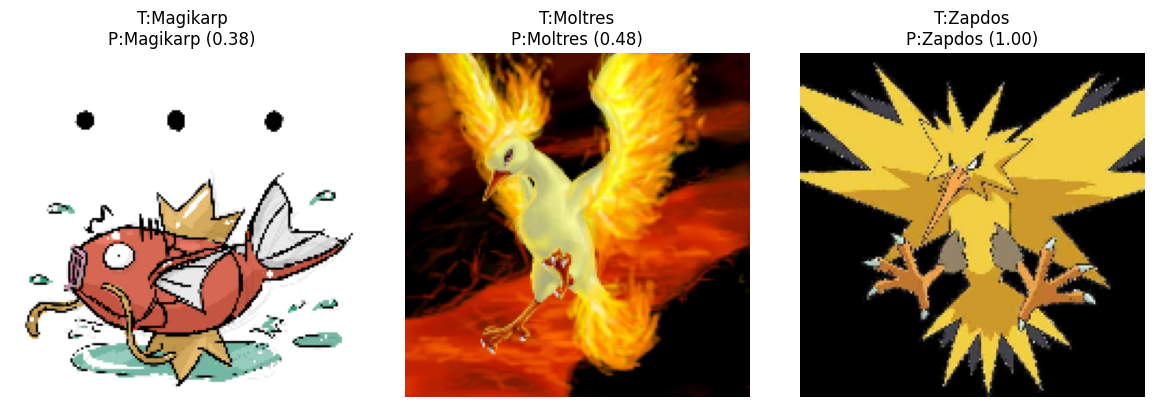

3 Wrong:


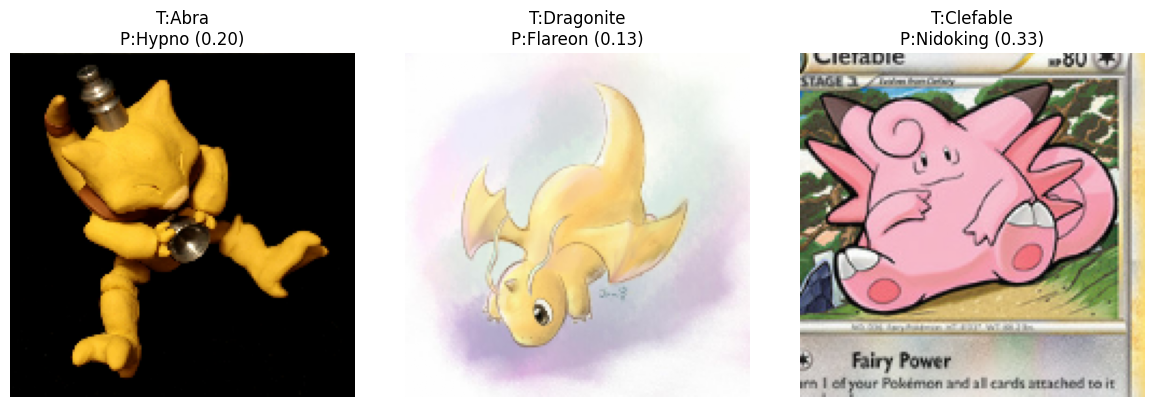

In [38]:
def show_examples(target_correct=True, k=3):
    got = 0
    plt.figure(figsize=(12, 4))
    for imgs, y in test_ds:
        probs = best_model.predict(imgs, verbose=0)
        preds = np.argmax(probs, axis=1)

        for i in range(len(y)):
            is_correct = (preds[i] == int(y[i]))
            if is_correct != target_correct:
                continue

            got += 1
            ax = plt.subplot(1, k, got)
            plt.imshow((imgs[i] / 255.0).numpy())
            t = id_to_label[int(y[i])]
            p = id_to_label[int(preds[i])]
            conf = float(probs[i, preds[i]])
            plt.title(f"T:{t}\nP:{p} ({conf:.2f})")
            plt.axis("off")

            if got >= k:
                plt.tight_layout()
                plt.show()
                return
    plt.show()

print("3 Correct:")
show_examples(target_correct=True, k=3)

print("3 Wrong:")
show_examples(target_correct=False, k=3)


## 23) Save final model


In [43]:
final_model_path = OUT_DIR / "pokemon_classifier_final.keras"
best_model.save(final_model_path)
print("Saved:", final_model_path)
print("Saved runs table:", OUT_DIR/"runs_table.csv")
print("Saved class mapping:", OUT_DIR/"class_mapping.json")


Saved: outputs\pokemon_classifier_final.keras
Saved runs table: outputs\runs_table.csv
Saved class mapping: outputs\class_mapping.json


In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

OUT_DIR = Path("outputs")
MODEL_PATH = OUT_DIR / "pokemon_classifier_final.keras"  
MAP_PATH   = OUT_DIR / "class_mapping.json"

# Load model (if you used custom loss earlier, compile=False avoids errors)
model = keras.models.load_model(MODEL_PATH, compile=False)

with open(MAP_PATH, "r", encoding="utf-8") as f:
    mapping = json.load(f)

# mapping might store keys as strings; normalize
id_to_label = mapping["id_to_label"]
id_to_label = {int(k): v for k, v in id_to_label.items()}

IMG_SIZE = (160, 160)  # must match training


Top predictions:
Bulbasaur       0.846
Ivysaur         0.062
Jigglypuff      0.025
Flareon         0.007
Clefairy        0.005


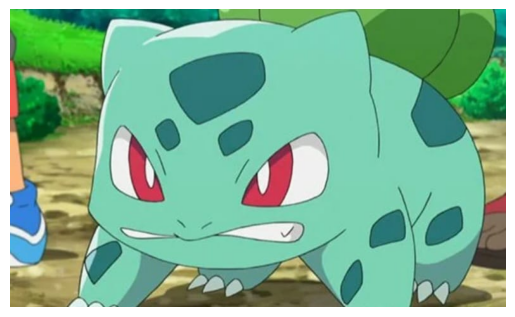

Top predictions:
Snorlax         0.632
Farfetchd       0.173
Primeape        0.023
Machamp         0.023
Mewtwo          0.021


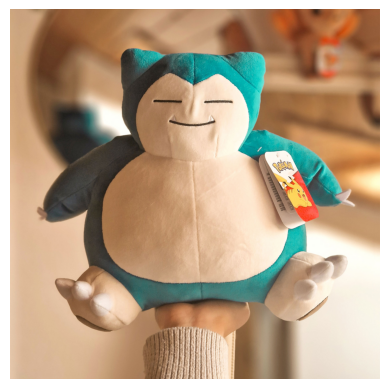

Top predictions:
Dodrio          0.883
Doduo           0.050
Fearow          0.009
Zubat           0.004
Primeape        0.003


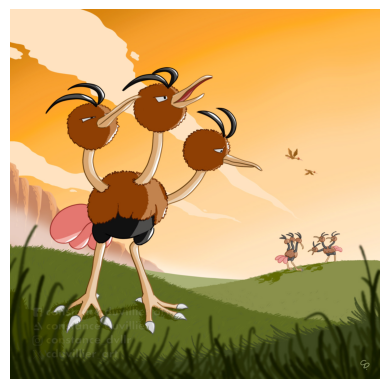

Top predictions:
Blastoise       0.822
Wartortle       0.112
Rhydon          0.022
Machop          0.005
Squirtle        0.005


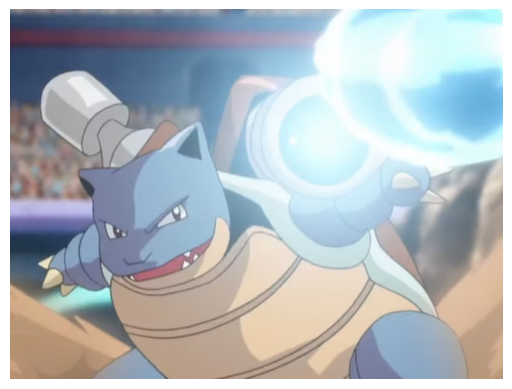

In [46]:
def predict_from_file(image_path, top_k=5):
    image_path = str(image_path)

    img = keras.utils.load_img(image_path, target_size=IMG_SIZE)
    x = keras.utils.img_to_array(img).astype("float32")
    x = np.expand_dims(x, axis=0)

    probs = model.predict(x, verbose=0)[0]
    idxs = np.argsort(probs)[::-1][:top_k]

    return [(id_to_label[int(i)], float(probs[i])) for i in idxs]

# Example:
predict_from_file("..\\pokemon\\balb2.jpeg", top_k=5)
predict_from_file("..\\pokemon\\Snorlax_1.jpg", top_k=5)
predict_from_file("..\\pokemon\\dodrio1.jpg", top_k=5)
predict_from_file("..\\pokemon\\Blastoise1.jpg", top_k=5)




import matplotlib.pyplot as plt

def show_file_prediction(image_path):
    preds = predict_from_file(image_path, top_k=5)
    print("Top predictions:")
    for name, p in preds:
        print(f"{name:15s} {p:.3f}")

    img = keras.utils.load_img(image_path)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

show_file_prediction("..\\pokemon\\balb2.jpeg")
show_file_prediction("..\\pokemon\\Snorlax_1.jpg")
show_file_prediction("..\\pokemon\\dodrio1.jpg")
show_file_prediction("..\\pokemon\\Blastoise1.jpg")


